In [2]:
import pickle as pck
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from functions_PDF import pdf_creator3x3, pdf_creator3x3_indexs, pdf_creator3x3_verticals
from functions_MuonsNSAMP1 import DataFrame_muons, pixel_rot

import skimage as sk
import scipy.ndimage as nd
import numpy.ma as ma


# from ROOT import TFile, TTree

## Configuración del estilo de las imágenes
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth":2,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',
})

colorbar='jet'
Norm = matplotlib.colors.LogNorm(vmin=10**-1, vmax=5 * 10**0)

In [4]:
######## Nueva definición de la elipcidad ############
# path = './Diccionarios_Espetro_Muones/dict_muons_NSAMP324_Extensions_1_2_4_NIMGS_393_SOL_0.65_ELIP_0.65_NSIGMAS_13_dEDL_0_SIZE_250x539_KeV_.pkl'
# path = './Diccionarios_Espetro_Muones/dict_muons_NSAMP324_Extensions_1_2_4_NIMGS_393_SOL_0.65_ELIP_0.65_NSIGMAS_13_DEDL_0_SIZE_250x539_KeV_n.pkl'
# path = './Diccionarios_Espetro_Muones/dict_muons_NSAMP324_Extensions_1_2_4_NIMGS_393_SOL_0.65_ELIP_0.65_NSIGMAS_13_DEDL_1100_SIZE_250x539_KeV_n.pkl'
path = './Diccionarios_Espetro_Muones/dict_muons_NSAMP324_Extensions_1_2_4_NIMGS_393_SOL_0.65_ELIP_0.65_NSIGMAS_13_DEDL_1400_SIZE_250x539_KeV_n.pkl'



histogram = open(path, 'rb')
data_histogram = pck.load(histogram)
histogram.close()

#### Visualizar las keys del diccionario ####
print('Las unidades de los datos están en: ', data_histogram['Energy_Units'])
print('Llaves principales del diccionario: ', data_histogram.keys())
print('Llaves secuandarias por extensión: ', data_histogram['extension_1'].keys(), end='\n\n')
# print(type(data_histogram['extension_1']['all_events']))
# data_muons_extension_1 = data_histogram['extension_1']
# data_muons_extension_2 = data_histogram['extension_2']
# data_muons_extension_4 = data_histogram['extension_4']
Ext = 2

# print(data_histogram['extension_1']['theta'])
n_muons = data_histogram['All_Muons_Detected']
print('Se detectaron ', n_muons, ' muones (contando las 3 extensiones)')
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)
# DF_muons['Phi (Deg)']

Las unidades de los datos están en:  2
Llaves principales del diccionario:  dict_keys(['Num_Images', 'All_Muons_Detected', 'Energy_Units', 'Elipticity', 'Solidity', 'Fit_errors', 'extension_1', 'extension_2', 'extension_4'])
Llaves secuandarias por extensión:  dict_keys(['charge', 'deltaEL', 'deltaL', 'all_events', 'theta', 'phi', 'gain', 'elip', 'sol', 'all_events_elip', 'all_events_sol', 'datamasked', 'run'])

Se detectaron  2833  muones (contando las 3 extensiones)


,date_run,Gain (ADU/e-),Solidity,Elipticity,Theta (Deg),Phi (Deg),Charge (KeV),l (cm),dEdL (KeV/cm)
Muon ID,,,,,,,,,
1,ENE2024,209.573664,0.833333,0.711954,28.184052,192.956772,262.850769,0.082252,3195.666966


Shape (Y, X):  (11, 25)


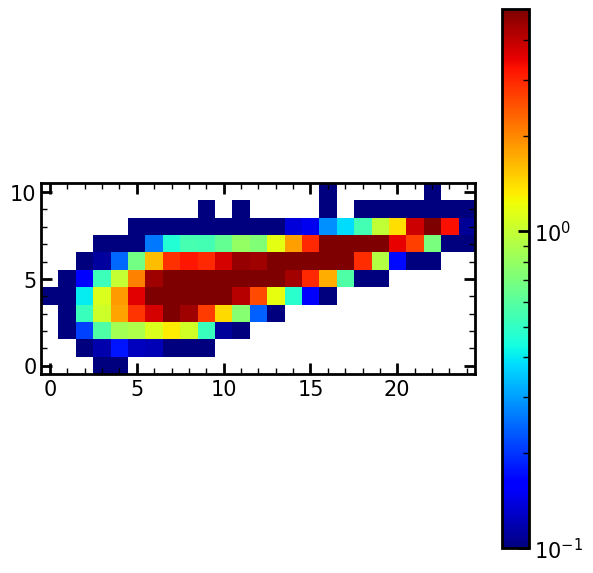

In [5]:
import matplotlib.colors


n_label = 1

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=[7,7])
x1 = axs.imshow(list_datamask[n_label], cmap=colorbar, norm=matplotlib.colors.LogNorm(vmin=10**-1, vmax=5 * 10**0))
fig.colorbar(x1, ax=axs)

display(DF_muons.iloc[[n_label]])
print('Shape (Y, X): ', list_datamask[n_label].shape)
plt.show()

Muons detected between the range:  351
Labels:  [3, 10, 14, 16, 21, 22, 25, 27, 35, 37, 41, 44, 45, 46, 53, 61, 65, 74, 76, 79, 84, 85, 88, 92, 99, 101, 112, 114, 121, 122, 124, 127, 129, 131, 132, 133, 140, 142, 148, 150, 151, 157, 158, 159, 163, 176, 182, 183, 186, 187, 188, 197, 204, 207, 211, 214, 217, 231, 243, 244, 245, 247, 248, 250, 264, 268, 269, 270, 278, 280, 282, 287, 294, 296, 302, 303, 304, 305, 308, 309, 310, 311, 312, 314, 315, 319, 320, 321, 326, 331, 335, 337, 339, 343, 354, 355, 358, 361, 362, 368, 378, 384, 391, 392, 393, 398, 402, 405, 407, 408, 413, 416, 418, 420, 423, 435, 436, 440, 443, 445, 451, 452, 455, 456, 457, 458, 462, 464, 465, 467, 468, 471, 473, 474, 479, 482, 495, 499, 501, 502, 508, 513, 515, 518, 526, 528, 534, 535, 538, 539, 540, 562, 563, 569, 571, 572, 573, 574, 575, 578, 579, 580, 589, 598, 606, 607, 611, 617, 622, 623, 624, 625, 632, 634, 635, 636, 641, 644, 647, 649, 651, 654, 662, 667, 668, 672, 674, 678, 686, 687, 688, 690, 692, 705, 709, 71

,date_run,Gain (ADU/e-),Solidity,Elipticity,Theta (Deg),Phi (Deg),Charge (KeV),l (cm),dEdL (KeV/cm)
Muon ID,,,,,,,,,
14,ENE2024,228.262584,0.816832,0.886923,49.963243,79.339357,278.519257,0.112704,2471.249191


Shape (Y, X):  (57, 15)


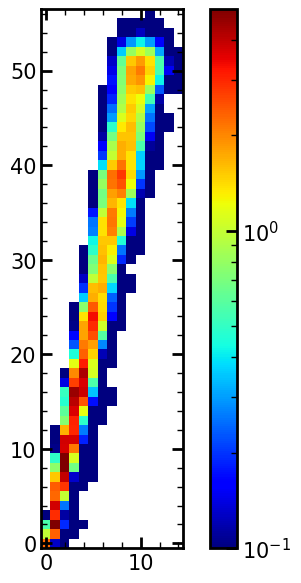

In [13]:
### Se crea el dataframe y se selecciona un rango de datos ###
Ext = 2
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)

list_newmatrix = []
list_indexs =[]
# range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(85, 95)]
range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(0, 90)]

for index in range_in_phi.index:
    # print(index)
    list_newmatrix.append(list_datamask[index])
    list_indexs.append(index)

print("Muons detected between the range: ", len(list_indexs))
print("Labels: ", list_indexs)

n_label = 14
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=[7,7])
x1 = axs.imshow(list_datamask[n_label], cmap=colorbar, norm=matplotlib.colors.LogNorm(vmin=10**-1, vmax=5 * 10**0))
fig.colorbar(x1, ax=axs)

display(DF_muons.iloc[[n_label]])
print('Shape (Y, X): ', list_datamask[n_label].shape)
plt.show()

In [14]:
list_phi_ext1 = data_histogram['extension_2']['phi']
list_mask_rot = []

list_listsnxny = []

for index in list_indexs[:]:
    datamask = list_datamask[index]
    ylen, xlen = datamask.shape
    list_nxny = []

    data_mask_zeros = np.empty((ylen + 90, xlen+50))
    data_mask_zeros[:] = 0
    ylen_zeros, xlen_zeros = data_mask_zeros.shape
    # print(data_mask_zeros.shape)
    
    ### Angle rot ##
    phi_rot = np.pi/2 - list_phi_ext1[index]
    # phi_rot = np.pi/2 
    # print(phi_rot, phi_rot + list_phi_ext1[index])

    # print('shape original: ', xlen, ylen)
    # print('shape zeros: ', xlen_zeros, ylen_zeros)

    for y_bin in range(0, ylen):
        for x_bin in range(0, xlen):
            if datamask[y_bin][x_bin] != 0:
                nx, ny = pixel_rot(x_bin=x_bin, x0=0, y_bin=y_bin, y0=0, theta= phi_rot)
                list_nxny.append((nx + 10, ny))
                # print(nx, ny)
                data_mask_zeros[ny][nx+10] = datamask[y_bin][x_bin]

    list_listsnxny.append(list_nxny)
    label_img, nlabels_img = sk.measure.label(data_mask_zeros > 0, connectivity=2, return_num=True)
    loc = nd.find_objects(label_img == 1)[0]
    mask_rot = np.invert(label_img==1)
    # data_mask_rot = ma.masked_array(data_mask_zeros, mask_rot)
    data_mask_rot = ma.masked_array(data_mask_zeros[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_rot[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    list_mask_rot.append(data_mask_rot)
    # print('Shape rot: ', data_mask_rot.shape[1], data_mask_rot.shape[0])
    
    # plt.imshow(data_mask_rot)
    # plt.show()
#     

In [8]:
# display(list_listsnxny[1]
dict_reps = {}
for duple in list_listsnxny[1]:
    dict_reps[duple] = dict_reps.get(duple, 0) + 1

# display(dict_reps)
n_valuesrep = 0
for value in dict_reps:
    if dict_reps[value]>1:
        n_valuesrep += 1
        print(value, ': ', dict_reps[value])

print('Elements with more reps: ', n_valuesrep)

(10, 0) :  3
(14, 2) :  2
(10, 1) :  2
(15, 3) :  2
(10, 2) :  2
(11, 3) :  2
(10, 3) :  2
(16, 6) :  2
(10, 4) :  2
(10, 5) :  2
(10, 6) :  2
(12, 7) :  2
(10, 8) :  2
(13, 10) :  2
(14, 11) :  2
(10, 10) :  2
(10, 12) :  3
(15, 15) :  2
(10, 14) :  2
(10, 15) :  2
(11, 16) :  2
(10, 16) :  2
(15, 19) :  2
(10, 17) :  2
(10, 18) :  2
(12, 20) :  2
(10, 20) :  2
(10, 21) :  2
(13, 22) :  2
(10, 22) :  2
Elements with more reps:  30


In [16]:
PDF_rot_name = 'Muons_PHI_BETWEEN_0-90_EXT2_DEDL_1400_rot.pdf'
# PDF_rot_name = 'Muons_PHI_BETWEEN_85-95_EXT1_DEDL_1400.pdf'
pdf_creator3x3_verticals(pdf_name=PDF_rot_name, list_pixelmatrix=list_mask_rot[:100])

The PDF is being created
100  muons will be display
Done


0

# Creación de PDF para todos los muones de una extensión

In [ ]:
n_label = 100

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=[7,7])
axs[0,0].imshow(list_datamask[n_label], cmap=colorbar)
axs[0,0].set_title('ID: ' + str(n_label))

axs[0,1].imshow(list_datamask[n_label+1], cmap=colorbar)
axs[0,1].set_title('ID: ' + str(n_label+1))

axs[0,2].imshow(list_datamask[n_label+2], cmap=colorbar)
axs[0,2].set_title('ID: ' + str(n_label+2))

axs[1,0].imshow(list_datamask[n_label+3], cmap=colorbar)
axs[1,0].set_title('ID: ' + str(n_label+3))

axs[1,1].imshow(list_datamask[n_label+4], cmap=colorbar)
axs[1,1].set_title('ID: ' + str(n_label+4))

axs[1,2].imshow(list_datamask[n_label+5], cmap=colorbar)
axs[1,2].set_title('ID: ' + str(n_label+5))

axs[2,0].imshow(list_datamask[n_label+6], cmap=colorbar)
axs[2,0].set_title('ID: ' + str(n_label+6))

axs[2,1].imshow(list_datamask[n_label], cmap=colorbar)
axs[2,1].set_title('ID: ' + str(n_label+7))

axs[2,2].imshow(list_datamask[n_label+8], cmap=colorbar)
axs[2,2].set_title('ID: ' + str(n_label+8))

plt.tight_layout()
plt.show()

In [19]:
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4, letter
from reportlab.lib.utils import ImageReader


Ext = 1  # Only change this value and the PDF_name

DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)

# list_datamask = list_datamask[:50]
print('Len: ', len(list_datamask))
### Creación del PDF con el nombre ##
PDF_name = 'All_Muons_Ext'+str(Ext)+'.pdf'
c = canvas.Canvas(PDF_name, letter)
w, h = A4 ## dimensiones del formato

### Imagen provicional ###
path_image = 'Perfil_Muon.jpg'
color_matrix = [0.4, 0.4470, 0.2410]
coord3x3 = [[0,0],[0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]
n_last_events = 0

# for extension in (1,2,4):
# c.drawString(50, h - 50, 'Extensión ' + str(Ext)) 
n_muonstot = len(list_datamask)
n_last_events = 0
n_events = 0


fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [6,6], facecolor = color_matrix) ## Las hojas tendrán 9 muones
num_pages = 0
# c.showPage()

if (n_muonstot%9) == 0:
    # print('Hola')
    for index in range(0, len(list_datamask)):
        n_muonstot = n_muonstot - 1
        n_events = n_events + 1
        if n_events < 10: 
            # print('n_events: ', n_events)
            axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].imshow(list_datamask[index], cmap = colorbar, norm = Norm)
            axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].set_title('ID: ' + str(index))

            if n_events == 9:
                n_events = 10
        
        if n_events == 10:
            n_events = 0
            num_pages = num_pages + 1
            fig.savefig(path_image)
            img = ImageReader(path_image)

            # Obtener el ancho y alto de la imagen.
            img_w, img_h = img.getSize()

            # h - img_h es el alto de la hoja menos el alto de la imagen.
            c.drawImage(img, w - img_w + 10, h - img_h - 90)
            c.drawString(w/2, 40, str(num_pages))
            c.showPage()
            # plt.imshow(event)
            # plt.show()
            plt.close()
            ! rm Perfil_Muon.jpg

            fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [6,6], facecolor = color_matrix)

elif (n_muonstot%9) != 0:
    # print('No Hola')
    Resto = n_muonstot%9

    for index in range(0, len(list_datamask)):
        n_muonstot = n_muonstot - 1
        n_events = n_events + 1

        if n_muonstot >= Resto:
            # print('Primera condicion')
            if n_events < 10: 
                # print('n_events: ', n_events)
                axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].imshow(list_datamask[index], cmap = colorbar, norm = Norm)
                axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].set_title('ID: ' + str(index))

                if n_events == 9:
                    n_events = 10

            if n_events == 10:
                # print('Estoy aqui')
                n_events = 0
                num_pages = num_pages + 1
                fig.savefig(path_image)
                img = ImageReader(path_image)

                # Obtener el ancho y alto de la imagen.
                img_w, img_h = img.getSize()
                # print('Aqui ', img_w)

                # h - img_h es el alto de la hoja menos el alto de la imagen.
                c.drawImage(img, w - img_w+10, h - img_h-90)
                c.drawString(w/2, 40, str(num_pages))
                c.showPage()
                # plt.imshow(event)
                # plt.show()
                plt.close()
                ! rm Perfil_Muon.jpg

                fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [6,6], facecolor = color_matrix)

        elif n_muonstot<Resto:
            # print('Segunda condicion')
            n_last_events = n_last_events + 1

            axs[coord3x3[n_last_events - 1][0],coord3x3[n_last_events - 1][1]].imshow(list_datamask[index], cmap=colorbar, norm = Norm)
            axs[coord3x3[n_last_events - 1][0],coord3x3[n_last_events - 1][1]].set_title('ID: ' + str(index))

            if n_muonstot == 0:
                # plt.show()
                num_pages = num_pages + 1
                fig.savefig(path_image)
                img = ImageReader(path_image)

                # Obtener el ancho y alto de la imagen.
                img_w, img_h = img.getSize()

                # h - img_h es el alto de la hoja menos el alto de la imagen.
                c.drawImage(img, w - img_w + 50, h - img_h - 60)
                c.drawString(w/2, 40, str(num_pages))
                c.showPage()
                # plt.imshow(event)
                # plt.show()
                plt.close()
                ! rm Perfil_Muon.jpg

                fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [10,10], facecolor = color_matrix)
        
plt.close()
c.save()

Len:  1138


# Creción de PDFs para un rango de datos

In [20]:
Ext = 2
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)

list_newmatrix = []
list_indexs =[]
# range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(165, 195)]
range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(85, 95)]

for index in range_in_phi.index:
    # print(index)
    list_newmatrix.append(list_datamask[index])
    list_indexs.append(index)

# plt.imshow(list_newmatrix[0])
# PDF_name = 'Muons_PHI_BETWEEN_0-90_EXT1_DEDL_1400.pdf'
PDF_name = 'Muons_PHI_BETWEEN_85-95_EXT' + str(Ext)+ '_DEDL_1400.pdf'
pdf_creator3x3_indexs(PDF_name, list_newmatrix, list_indexs)


The PDF is being created
33  muons will be display
Done


0